### Otimização dos Dados

- Nesta etapa, buscamos ajustar os dados conforme vemos necessidade, para que o aumento da performance dos modelos;

- Começamos analisando quais são as *features* mais importantes na classificação.

In [228]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score

In [229]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [230]:
def get_data(train_path, test_path):

    df_train = pd.read_csv(train_path, header=0)
    df_test = pd.read_csv(test_path, header=0)

    data = df_train.to_numpy()
    n_row, n_col = data.shape
    X = data[:,1:n_col]
    y = data[:,0]
    X_test = df_test.to_numpy()

    return X, y, X_test 

def get_scale(train, test):
    scaler = StandardScaler()
    train = scaler.fit_transform(train)
    test = scaler.transform(test)
    return train, test

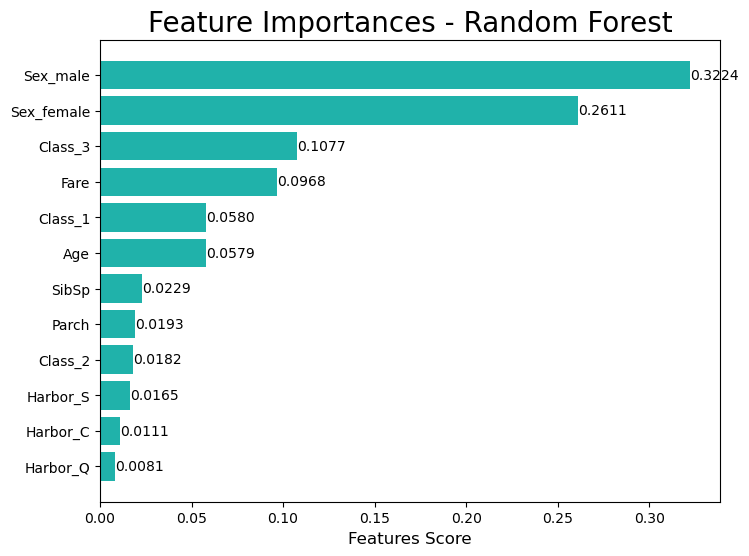

In [231]:
from sklearn.ensemble import RandomForestClassifier

df_train = pd.read_csv("dados/treino_tratado.csv", header=0)
X, y, X_test = get_data("dados/treino_tratado.csv", "dados/teste_tratado.csv")

rfc = RandomForestClassifier(max_depth=9, min_samples_leaf=15, min_samples_split=20, random_state=42)
rfc.fit(X, y)

df_train = df_train.drop("Survived", axis=1)
features = list(df_train.columns)
features_importance = list(rfc.feature_importances_)

dados_ordenados = list(zip(features, features_importance))
dados_ordenados.sort(key=lambda x: x[1], reverse=False) 
features, features_importance = zip(*dados_ordenados)

plt.figure(figsize=(8,6))
plt.barh(features, features_importance, color="lightseagreen")
plt.title("Feature Importances - Random Forest", fontsize=20)
plt.xlabel("Features Score", fontsize=12)
for index, value in enumerate(features_importance):
    plt.text(value, index, f'{value:.4f}', ha='left', va='center', fontsize=10, color='black')
plt.show()

- Como o modelo de KNeighbors não possui ferramenta para visualizar as *features* mais importantes, então consideramos somente o modelo de Random Forest.

- Vemos que a coluna de sexo e classe do conjunto inicial tem uma importância considerável para o modelo, além disso, devemos ver que a coluna de idade também é importane na predição, e com isso, podemos pensar no peso do tratamento que demos aos dados fatantes na mesma. Ou seja, podemos nos perguntar se há uma melhor forma de preencher os dados faltantes da coluna de idade.

- Para efetuar este processo, separamos os dados de treino em dois conjuntos, no qual, um não terá a informação das idades e será, portanto, o dado de teste_idade.

In [255]:
#importação dos dados originais do kaggle

df_train = pd.read_csv("dados/train.csv", header=0)
df_test = pd.read_csv("dados/test.csv", header=0)

#Exclusão das colunas não importantes

PassengerID = df_test["PassengerId"]
df_test = df_test.drop(["Name", "Ticket", "Cabin", "PassengerId"], axis=1)
Survived_train = df_train["Survived"]
df_train = df_train.drop(["Name", "Ticket", "Cabin", "PassengerId", "Survived"], axis=1)

#Preenchimento dos dados faltantes nas colunas exceto da idade

df_test["Fare"] = df_test["Fare"].fillna(df_test["Fare"].mean())
df_train["Fare"] = df_train["Fare"].fillna(df_train["Fare"].mean())
df_train["Embarked"] = df_train["Embarked"].fillna(df_train["Embarked"].mode()[0])

#Tratamento dos dados categóricos

df_train = pd.get_dummies(df_train, columns=["Sex", "Embarked", "Pclass"], prefix=["Sex", "Harbor", "Class"])
df_test = pd.get_dummies(df_test, columns=["Sex", "Embarked", "Pclass"], prefix=["Sex", "Harbor", "Class"])

#Separação do conjunto de treino em conjuntos de treino e teste para preencher a idade 
 
df_train_test_age = df_train[df_train["Age"].isna()]
df_train_train_age = df_train.dropna()

data_train = df_train_train_age.to_numpy()
n_row, n_col = data_train.shape
X_train_train = data_train[:,1:n_col]
y_train_train = data_train[:,0]

data_test = df_train_test_age.to_numpy()
n_row, n_col = data_test.shape
X_test_train = data_test[:,1:n_col]
y_test_train = data_test[:,0]

#Separação do conjunto de treino em conjuntos de treino e teste para preencher a idade 
 
df_test_null= df_test[df_test["Age"].isna()]

data_test = df_test_null.to_numpy()
n_row, n_col = data_test.shape
X_test_null = data_test[:,1:n_col]
y_test_null = data_test[:,0]

- Antes de selecionar os modelos para a regressão, avaliamos como se comportam os dados e qual o score obtido pela substituição da média nos dados faltantes, para isso vamos utilizar a métricas relativas **r2_score** e **mean_absolute_percentage_error** e a métrica absoluta **mean_absolute_error**.

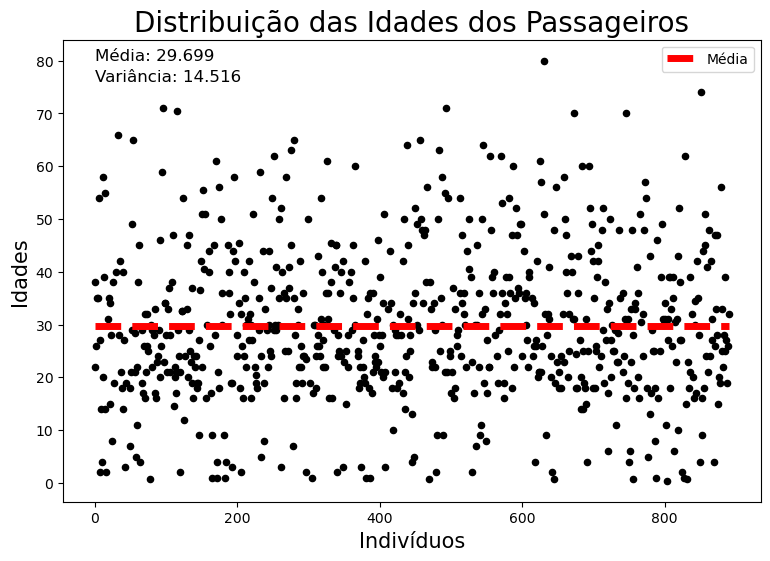

In [233]:
mean_age_train = len(y_train_train)*[np.mean(y_train_train)]
std = len(y_train_train)*[np.std(y_train_train)]

plt.figure(figsize=(9,6))
plt.scatter(df_train_train_age.index, y_train_train, s=20, c="black")
plt.plot(df_train_train_age.index, mean_age_train, "--", c="r", linewidth="5", label="Média")
plt.text(0, 80, f"Média: {np.mean(y_train_train):.3f}", fontsize=12)
plt.text(0, 76, f"Variância: {np.std(y_train_train):.3f}", fontsize=12)
plt.title("Distribuição das Idades dos Passageiros", fontsize=20)
plt.xlabel("Indivíduos", fontsize=15)
plt.ylabel("Idades", fontsize=15)
plt.legend()
plt.show()

- Vemos que as idades estão muito dispersas sobre a média, esperamos que os erros sejam altos na predição.

In [234]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train_train, y_train_train, test_size=0.2, random_state=42)

mean_age_train = len(y_valid)*[np.mean(y_train)]

print(f"Erro relativo da substituição pela média: \n r2 score: {r2_score(y_valid, mean_age_train):.3f} \n"
                                                    f" Média Percentual dos Erros: {mean_absolute_percentage_error(y_valid, mean_age_train):.3f}")
print(f"Erro absoluto da substituição pela média: {mean_absolute_error(y_valid, mean_age_train):.3f}")

Erro relativo da substituição pela média: 
 r2 score: -0.014 
 Média Percentual dos Erros: 1.000
Erro absoluto da substituição pela média: 11.007


- Como esperado, obtivemos erros relativos muito altos, a métrica r2_score negativa demonstra que em alguns casos o erro poder ser maior que a variância dos dados, portanto, vamos tentar melhorar o preenchimento com alguns modelos de regressão.

- Para a regressão dos dados faltantes da idade, utilizaremos os seguintes modelos presentes no **Scikit Learning**: **Polinomial e Linear Regression**, **KNeighbors**, **SVR** e **RandomForest**, além do modelo **XGBoost**.

- Vamos testar os modelos primeiro em estado *default* e se for necessário otimizamos os parâmetros, começando pela [Regressão Linear]( https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) e **Regressão Polinomial** de segunda ordem.

In [235]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scale = scaler.fit_transform(X_train_train)
y_before_scale = y_train_train.reshape(-1,1)
y_scale = scaler.fit_transform(y_before_scale)

In [236]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

poly_order = [1,2]
metrics = ["r2", "neg_mean_absolute_error"]
score_poly = {d: [] for d in metrics}
lf = LinearRegression()

for i in poly_order: 
    for j in metrics:
        X = X_train_train
        X = PolynomialFeatures(degree=i).fit_transform(X_train_train)
        results_poly = cross_val_score(lf, X, y_train_train, cv=5, scoring=j)
        score_poly[j].append(np.round(results_poly.mean(), 3))



print(f"Resultado da regressão linear e polinomial: \n R² = {score_poly['r2']} ")
print(f" Média Absoluta = {score_poly['neg_mean_absolute_error']}")




Resultado da regressão linear e polinomial: 
 R² = [0.211, 0.087] 
 Média Absoluta = [-10.042, -10.25]


- Vemos que a regressão linear performou um pouco melhor que a de segundo ordem, agora vamos testar o modelo de **KNeighbors**.

In [239]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
score_knn = []

for i in metrics:
    results_knn = cross_val_score(knn, X_scale, y_scale.ravel(), cv=5, scoring=i)
    score_knn.append(np.round(results_knn.mean(), 3))

print(f"Resultado do modelo de KNeighbors: \n R² = {score_knn[0]} \n"
                                    f" Média Absoluta = {score_knn[1]}")

Resultado do modelo de KNeighbors: 
 R² = 0.13 
 Média Absoluta = -0.718


- Vamos testar o **SVR**, um modelo de regressão baseado em Suport Vectors Machine.

In [238]:
from sklearn.svm import SVR

svr = SVR()
score_svr = []


for i in metrics:
    results_svr = cross_val_score(svr, X_scale, y_scale.ravel(), cv=5, scoring=i)
    score_svr.append(np.round(results_svr.mean(), 3))

print(f"Resultado do modelo de SVR: \n R² = {score_svr[0]} \n"
                                    f" Média Absoluta = {score_svr[1]}")

Resultado do modelo de SVR: 
 R² = 0.229 
 Média Absoluta = -0.663


- Agora, testamos o modelo de **Random Forest**.

In [240]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
score_rf = []

for i in metrics:
    results_rf = cross_val_score(rf, X_train_train, y_train_train, cv=5, scoring=i)
    score_rf.append(np.round(results_rf.mean(), 3))

print(f"Resultado do modelo de RandomForest: \n R² = {score_rf[0]} \n"
                                    f" Média Absoluta = {score_rf[1]}")


Resultado do modelo de RandomForest: 
 R² = 0.138 
 Média Absoluta = -10.261


- O próximo modelo a ser testado será o [XGBoost](https://xgboost.readthedocs.io/en/stable/), o qual se baseia em árvores de decisão com mecanismos matemáticos diferentes do **RandomForest**.

In [241]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
score_xgb = []

for i in metrics:
    results_xgb = cross_val_score(xgb, X_train_train, y_train_train, cv=5, scoring=i)
    score_xgb.append(np.round(results_xgb.mean(), 3))

print(f"Resultado do modelo de XGBoost: \n R² = {score_xgb[0]} \n"
                                    f" Média Absoluta = {score_xgb[1]}")


Resultado do modelo de XGBoost: 
 R² = 0.025 
 Média Absoluta = -10.874


- Observamos que mesmo com um modelo robusto como o **XGBoost**, os melhores resultados foram obtidos por modelos simples como a **Regressão Linear** e o **SVR**.

- Podemos ainda, tentar melhorar a predição da idade, ajustando alguns **hiperparâmetros** do modelo de **SVR**

In [242]:
from sklearn.model_selection import RandomizedSearchCV

svr = SVR(degree=1)

params = {
    "C": [0.01, 0.05, 0.1, 0.5, 1],
    "kernel": ["linear", "poly", "rbf"]    
}

tun_params_svr = RandomizedSearchCV(estimator=svr, param_distributions=params, cv=5, random_state=42, scoring="r2")
model_svr = tun_params_svr.fit(X_scale, y_scale.ravel())

print(f"Melhores Parâmetros {model_svr.best_params_} \n Melhor Score {model_svr.best_score_}")

Melhores Parâmetros {'kernel': 'rbf', 'C': 0.5} 
 Melhor Score 0.23236403423361324


- Agora, vamos substituir os dados das idades obtidos pela Regressão Linear e por SVR e verificar se houve alguma alteração na predição de sobreviventes.

- Tratando com LinearRegression

In [256]:
lr = LinearRegression()

model = lr.fit(X_train_train, y_train_train)

#Construindo os dados faltantes da coluna nos conjuntos de treino e teste

y_pred_train = model.predict(X_test_train)
y_pred_test = model.predict(X_test_null)

df_train_test_age["Age"] = y_pred_train
df_test_null["Age"] = y_pred_test

#Concatenando os dados com o conjunto inicial

for index, row in df_train.iterrows():
    if pd.isna(row["Age"]):
        df_train.at[index, "Age"] = df_train_test_age.at[index, "Age"]

for index, row in df_test.iterrows():
    if pd.isna(row["Age"]):
        df_test.at[index, "Age"] = df_test_null.loc[index, "Age"]

df_train.insert(0, "Survived", Survived_train)

/tmp/ipykernel_7317/3986489340.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_age["Age"] = y_pred_train
/tmp/ipykernel_7317/3986489340.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_null["Age"] = y_pred_test


- Tratando com SVR

In [251]:
svr = SVR(kernel='rbf', C=0.5)

#Alterando a escala dos dados de treino e predição

scaler_1 = StandardScaler()
X_scale = scaler_1.fit_transform(X_train_train)
X_test_train = scaler_1.transform(X_test_train)
X_test_null = scaler_1.transform(X_test_null)

scaler_2 = StandardScaler()
y_before_scale = y_train_train.reshape(-1,1)
y_scale = scaler_2.fit_transform(y_before_scale)

model = svr.fit(X_scale, y_scale)

#Construindo os dados faltantes da coluna nos conjuntos de treino e teste

y_pred_train = model.predict(X_test_train)
y_pred_test = model.predict(X_test_null)

#Voltando a escala original dos dados preditos

y_pred_train = y_pred_train*scaler_2.scale_ + scaler_2.mean_
y_pred_test = y_pred_test*scaler_2.scale_ + scaler_2.mean_

df_train_test_age["Age"] = y_pred_train
df_test_null["Age"] = y_pred_test

#Concatenando os dados com o conjunto inicial

for index, row in df_train.iterrows():
    if pd.isna(row["Age"]):
        df_train.at[index, "Age"] = df_train_test_age.at[index, "Age"]

for index, row in df_test.iterrows():
    if pd.isna(row["Age"]):
        df_test.at[index, "Age"] = df_test_null.loc[index, "Age"]

df_train.insert(0, "Survived", Survived_train)

/home/edmurcn/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/tmp/ipykernel_7317/2224825022.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_age["Age"] = y_pred_train
/tmp/ipykernel_7317/2224825022.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_null["Age"] = y_pred

In [252]:
df_train.to_csv("dados/treino_tratado_2.csv", index=False)
df_test.to_csv("dados/teste_tratado_2.csv", index=False)

In [253]:
X, y, X_test = get_data("dados/treino_tratado_2.csv", "dados/teste_tratado_2.csv")

rfc_final = RandomForestClassifier(max_depth=9, min_samples_leaf=5, min_samples_split=10, random_state=42)
model_rfc = rfc_final.fit(X,y)
y_pred = model_rfc.predict(X_test)

prediction_rfc = pd.DataFrame()

PassengerId = pd.read_csv("dados/passengerid.csv", header=0)
PassengerId = np.array(PassengerId["PassengerId"], dtype="int")
y_pred = np.array(y_pred, dtype="int")
prediction_rfc["PassengerId"] = PassengerId
prediction_rfc["Survived"] = y_pred
prediction_rfc.to_csv('dados/prediction_rfc2_svr.csv', index=False)

In [254]:
from sklearn.neighbors import KNeighborsClassifier

X, X_test = get_scale(X, X_test)

knn_final = KNeighborsClassifier(n_neighbors=28, metric='cosine')
model_knn = knn_final.fit(X,y)
y_pred = model_knn.predict(X_test)

prediction_knn = pd.DataFrame()

y_pred = np.array(y_pred, dtype="int")
prediction_knn["PassengerId"] = PassengerId
prediction_knn["Survived"] = y_pred
prediction_knn.to_csv('dados/prediction_knn2.csv', index=False)

- Os resultados obtidos pelos modelos de Random Forest e KNN no Kaggle, respectivamente, foram **0.78229** e **0.77272**.
  
- Concluímos que a alteração dos dados não surtiram muito efeito nos modelos, porém, observando as métricas ao preencher os dados pelo modelo de Regressão Linear, acredito que trará melhores resultados em conjunto com o ajuste de outras *features*.